In [1]:
import os

# Evaluating the SemEval2020 task
This notebook is to evaluate several (historical) language models for English on the [SemEval2020 Shared Task](https://aclanthology.org/2020.semeval-1.1) on semantic change prediction.
I only evaluate subtask 2 (ranked shift prediction) for English and I reuse the code of [Kutosov and Giulianelli](https://github.com/Semantics-of-Sustainability/semeval2020). Their model ranks highest in the post-evaluation leaderboard, using bert-base-cased.

The models that we try out are:
- bert-base-uncased
- [HistLM](https://github.com/Living-with-machines/histLM)
- [MacBERTh](https://huggingface.co/emanjavacas/MacBERTh/tree/main)
- [TemporalAttention](https://github.com/Semantics-of-Sustainability/temporal_attention)

To replicate the steps this notebook, you need to also:
- Clone the [HistLM](https://github.com/Living-with-machines/histLM) repository
- Clone our fork of the [TemporalAttention](https://github.com/Semantics-of-Sustainability/temporal_attention) repository
- Download the [Evaluation data for SemEval2020](https://competitions.codalab.org/competitions/20948#learn_the_details-data)
- To run the Temporal Attention model, you need to rename / move some of the data files to get it to work. 

## Step 1: removing pos tag from semeval data
The target words contain the pos tags, create a file without pos tags.

In [2]:
# Remove the POS tags from the targets
inp_filename = '../../data/semeval2020_ulscd_eng/targets.txt'
outp_filename = '../../data/semeval2020_ulscd_eng/targets_nopos.txt'

with open(outp_filename, 'w') as fout:
    with open(inp_filename) as fin:
        for line in fin.readlines():
            word = line.split('_')[0]
            fout.write(word)
            fout.write('\n')

## Step 2: run embeddings for the model
Run the script [semeval2020/code/bert/collect.py](https://github.com/akutuzov/semeval2020/blob/master/code/bert/collect.py) for the different models and for the two copora. For example for bert-base-uncased, and corpus1:
```bash
python code/bert/collect.py data/configs/bert-base-uncased.txt ../data/semeval2020_ulscd_eng/corpus1/token/ccoha1.txt ../data/semeval2020_ulscd_eng/targets_nopos.txt ../data/corpus1_bert-base-uncased.npz
```

For the temporal attention model, I used the [adjusted code for semantic change detection](https://github.com/Semantics-of-Sustainability/temporal_attention/blob/main/semantic_change_detection.py). Note that this script also computes a score, but this is based only on cosine distance between embedding centroid. To have a fair comparison, I also output the raw embeddings of all target words. I did not manage yet to output embeddings of all layers, so the dimension of the embedding is much smaller than for the other models.


## Step 3: output list of words for each model.
The models will not find all words in the corpus. The code below outputs for each model, the words that were retrieved from the corpus.

In [10]:
import numpy as np

def output_words(corpus_filepath1, corpus_filepath2, output_file):
    test_corpus_file1 = np.load(corpus_filepath1)
    test_corpus_file2 = np.load(corpus_filepath2)
    words = set(test_corpus_file1.files).intersection(test_corpus_file2.files)
    with open(output_file, 'w') as fout:
        for word in words:
            fout.write(word+'\n')

In [22]:
output_words('../../data/corpus1_macberth.npz', '../../data/targets_macberth.txt')

In [30]:
output_words('../../data/corpus1_bert-base-uncased.npz', '../../data/corpus2_bert-base-uncased.npz', '../../data/targets_bert-base-uncased.txt')

In [3]:
output_words('../../data/corpus1_histLM.npz','../../data/corpus2_bert-base-uncased.npz', '../../data/targets_histlm.txt')

In [12]:
output_words('../../temporal_attention/data/semeval_eng/corpus1.npz',
             '../../temporal_attention/data/semeval_eng/corpus1.npz', 
             '../../data/targets_temporalattention.txt')

## Step 4: calculate the shifts
Run the shift predictions as [described here](https://github.com/akutuzov/semeval2020#estimating-semantic-change). For example:
```
python code/distance.py ../data/targets_bert-base-uncased.txt  ../data/corpus1_bert-base-uncased.npz  ../data/corpus2_bert-base-uncased.npz ../data/semeval2020_ulscd_eng/prediction_bert-base-uncased_apd.txt
```

NB: for the HistLM model, I applied it only on corpus1 and compared it to the bert-base-uncased embeddings of corpus2, because the HistLM model was finetuned from bert-base-uncased to data from before 1900.


## Step 5: Evaluate the predictions

In [1]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
# These are the 'true' semantic shifts from subtask 2
targets = pd.read_csv('../../data/semeval2020_ulscd_eng/truth/graded.txt', sep='\t', header=None)
targets.columns = ['word_pos', 'score']
targets['word'] = [w.split('_')[0] for w in targets['word_pos']]
targets = targets.sort_values('score')
targets['rank'] = range(len(targets))
targets.head()

,word_pos,score,word,rank
4,chairman_nn,0.000000,chairman,0
28,risk_nn,0.000000,risk,1
10,fiction_nn,0.020723,fiction,2
27,relationship_nn,0.056218,relationship,3
34,tree_nn,0.070839,tree,4


In [3]:
def load_predictions(filepath, targets):
    predictions = pd.read_csv(filepath, sep='\s+', header=None)
    predictions.columns = ['word', 'score']
    scores_merged = predictions.merge(targets, on='word', how='right', suffixes=('_pred', '_true'))

    # For those words where we don't have a predicted score, take the mean score
    scores_merged['in_model'] = ~scores_merged['score_pred'].isna()
    scores_merged.loc[~scores_merged['in_model'], 'score_pred'] = predictions['score'].mean()

    # Calculate the rank
    scores_merged = scores_merged.sort_values('score_pred')
    scores_merged['rank_pred'] = range(len(scores_merged))
    scores_merged = scores_merged.rename({'rank': 'rank_true'}, axis='columns')
    return scores_merged

In [4]:
def plot_predictions(predictions, name):
    correlation, pvalue = spearmanr(predictions['score_true'], predictions['score_pred'])
    plt.figure(figsize=(20,10))
    plt.scatter(x=predictions['rank_true'], 
            y=predictions['rank_pred'])
    for i in range(len(predictions)):
        plt.text(x=predictions['rank_true'][i],
            y=predictions['rank_pred'][i],
            s=predictions['word'][i])
    plt.title(f'{name}: {correlation:.3f}, {pvalue:.3f}')
    plt.show()
    return correlation, pvalue

In [5]:
from pathlib import Path
prediction_path = Path('../data/semeval2020/')
models = [
    [prediction_path / 'prediction_cosine_macberth.txt', 'macberth', 'cosine'],
    [prediction_path / 'prediction_apd_macberth.txt', 'macberth', 'apd'],
    [prediction_path / 'prediction_jsd_macberth.txt', 'macberth', 'jsd'],
    [prediction_path / 'prediction_bert-base-uncased_cosine.txt', 'bert-base-uncased', 'cosine'],
    [prediction_path / 'prediction_bert-base-uncased_apd.txt', 'bert-base-uncased', 'apd'],
    [prediction_path / 'prediction_histLM_bertbase_cosine.txt', 'histLM', 'cosine'],
    [prediction_path / 'prediction_histLM_bertbase_adp.txt', 'histLM', 'apd']
]
models_df = pd.DataFrame(models, columns=['filename', 'model', 'method'])
models_df

,filename,model,method
0,..\data\semeval2020\prediction_cosine_macberth...,macberth,cosine
1,..\data\semeval2020\prediction_apd_macberth.txt,macberth,apd
2,..\data\semeval2020\prediction_jsd_macberth.txt,macberth,jsd
3,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,cosine
4,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,apd
5,..\data\semeval2020\prediction_histLM_bertbase...,histLM,cosine
6,..\data\semeval2020\prediction_histLM_bertbase...,histLM,apd


In [6]:
predictions_dict = {i: load_predictions(row['filename'], targets) for i, row in models_df.iterrows()}


In [7]:
models_df['nr_words'] = [predictions_dict[i]['in_model'].sum() for i in models_df.index]

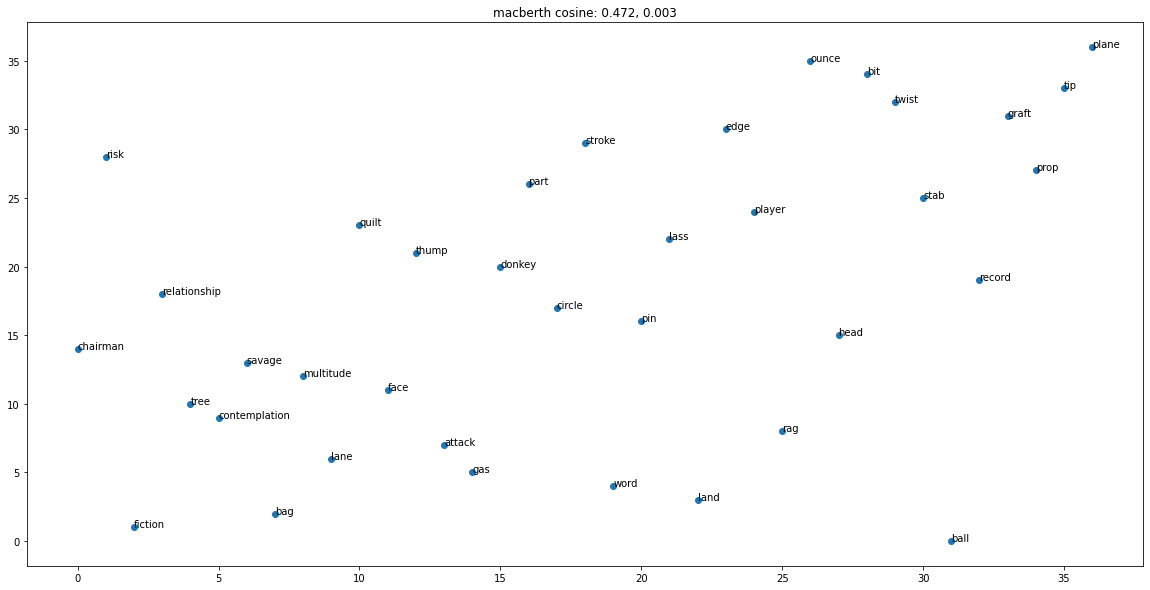

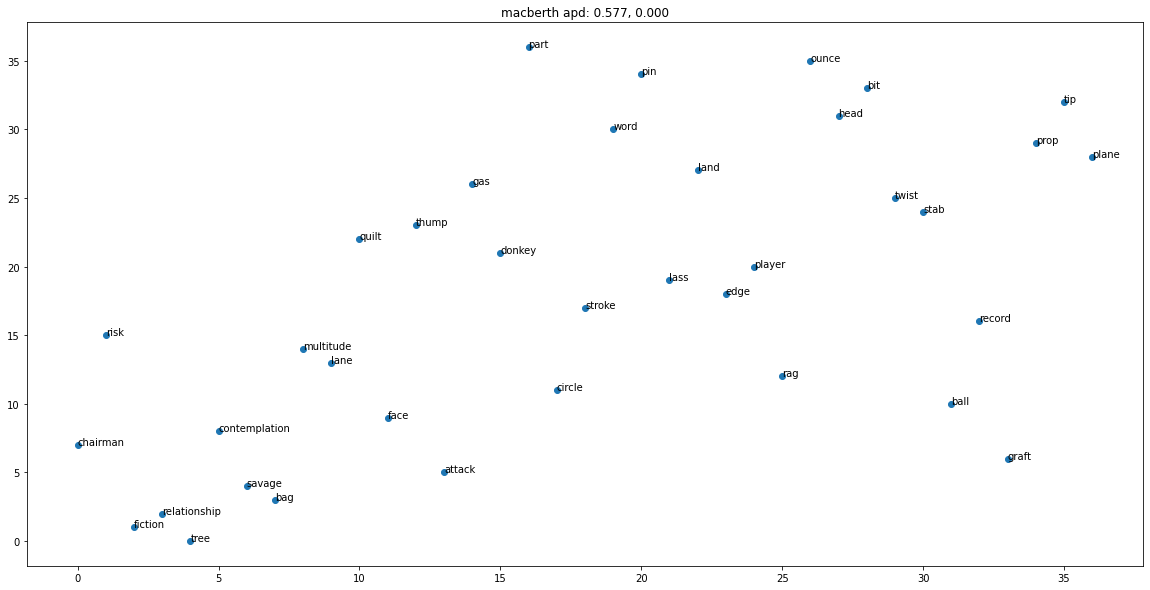

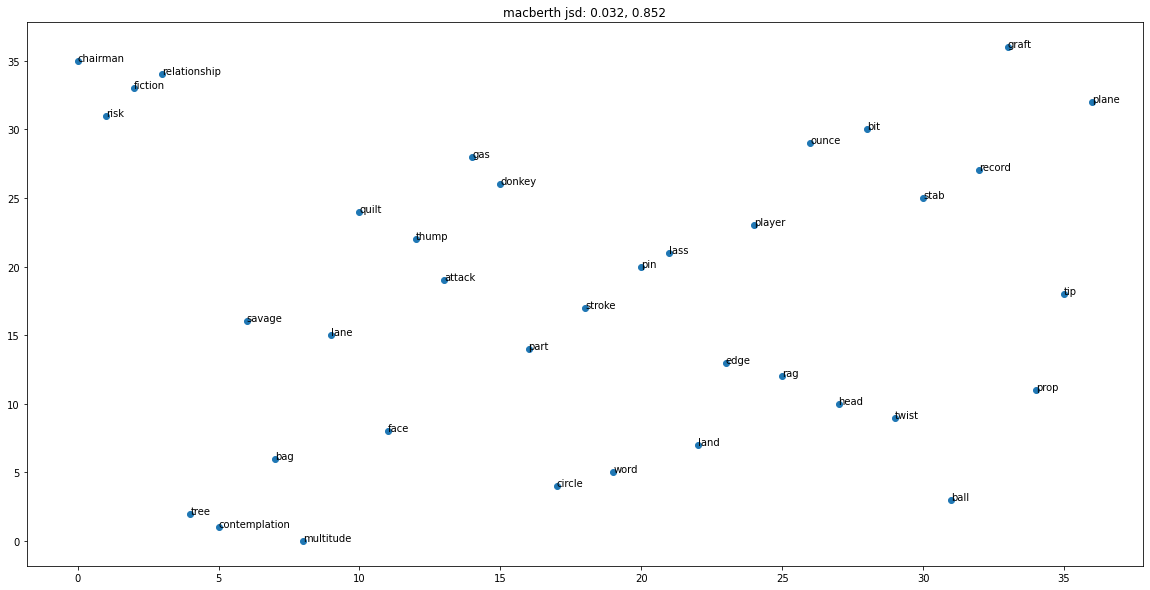

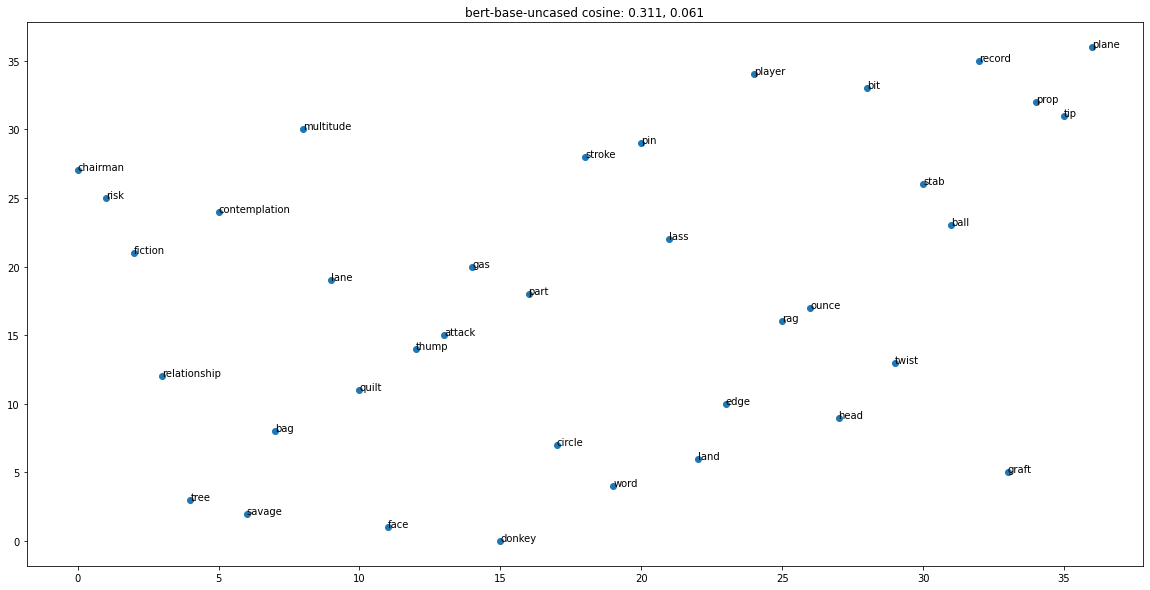

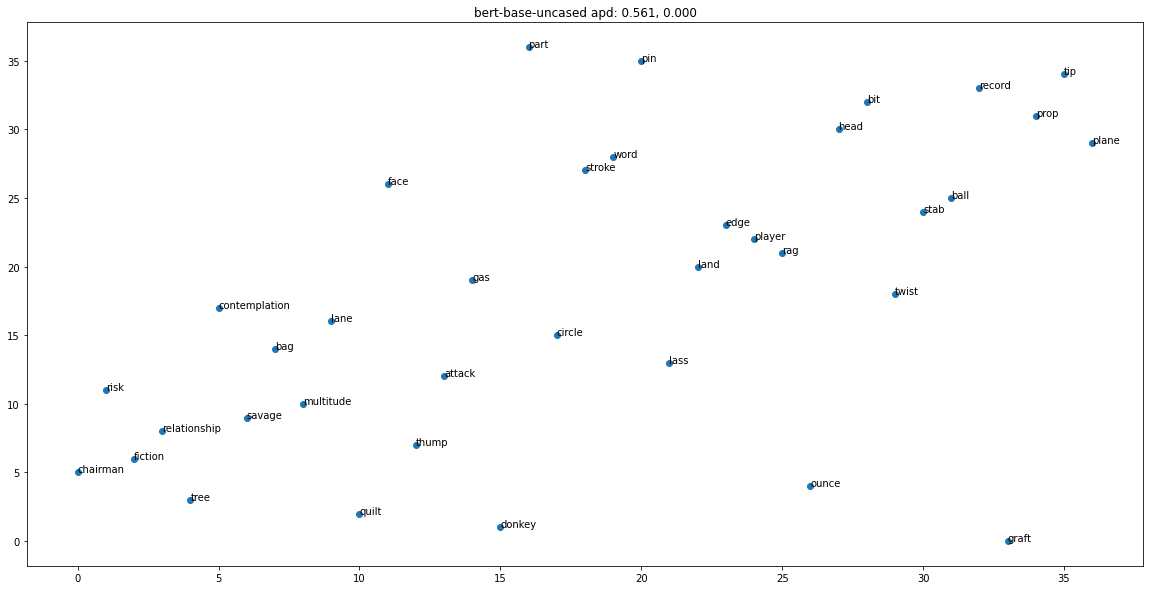

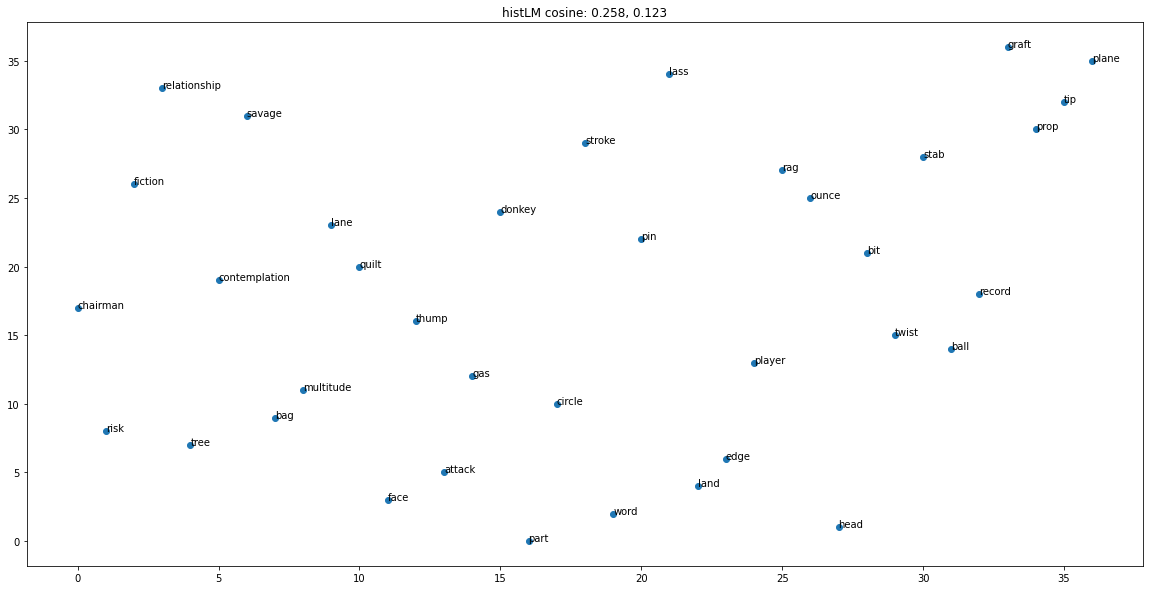

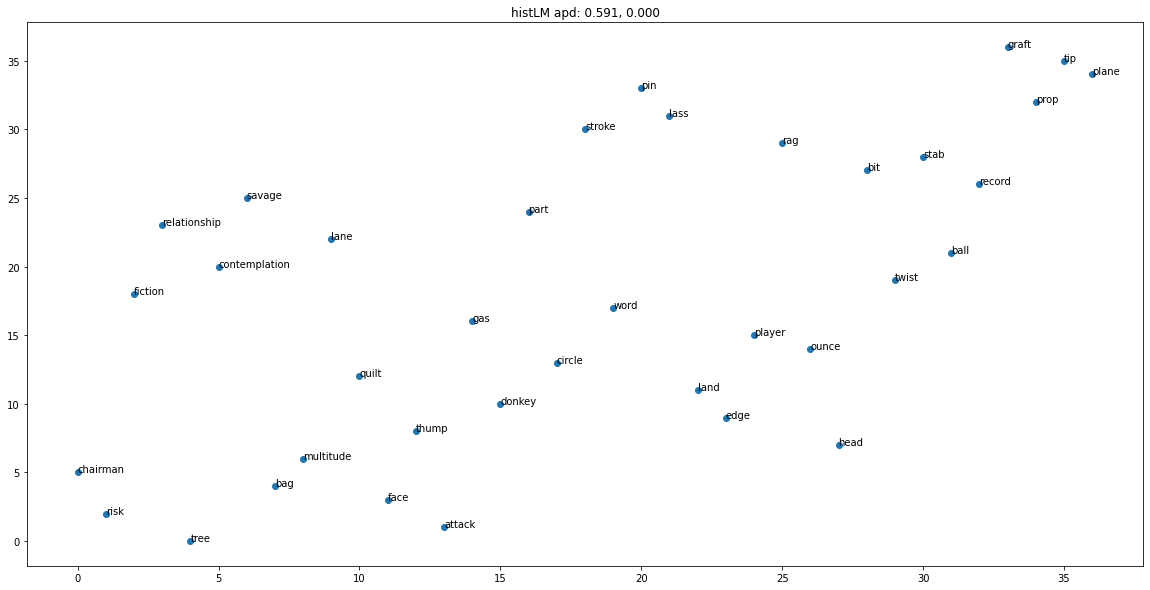

In [8]:
models_df['correlation'] = None
models_df['pvalue'] = None
for i, row in models_df.iterrows():
    cor, pv = plot_predictions(predictions_dict[i], f'{row["model"]} {row["method"]}')
    models_df.loc[i, 'correlation'] = cor
    models_df.loc[i, 'pvalue'] = pv   

In [9]:
models_df

,filename,model,method,nr_words,correlation,pvalue
0,..\data\semeval2020\prediction_cosine_macberth...,macberth,cosine,31,0.472259,0.003165
1,..\data\semeval2020\prediction_apd_macberth.txt,macberth,apd,31,0.577047,0.000185
2,..\data\semeval2020\prediction_jsd_macberth.txt,macberth,jsd,31,0.031722,0.852148
3,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,cosine,36,0.31051,0.061419
4,..\data\semeval2020\prediction_bert-base-uncas...,bert-base-uncased,apd,36,0.561029,0.000304
5,..\data\semeval2020\prediction_histLM_bertbase...,histLM,cosine,36,0.258107,0.122981
6,..\data\semeval2020\prediction_histLM_bertbase...,histLM,apd,36,0.590551,0.000119
